In [2]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [3]:
path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/"
pipeline_dir_path = path+"GaussianNN_CGW/Model_Pipeline/"
temp_files_path = pipeline_dir_path+'TempFiles/'


# Load the data and make Test/Valid/Train Splits

In [4]:
#### different commented out lines are different datasets: ####

# Non Periodogram Versions
#data=Table.read(path+'data/Stats_Table_For_Data_augmented_lcs_v2.fits', format='fits') #Length 46889
        # Cut in half + 12 day rolling window
#data=Table.read(path+'data/Stats_Table_For_all_Clusters_all_sectors_w_entropy.fits', format='fits') # 2204
        # Just sector lightcurves
        # every lc here is ~27 days
#data=Table.read(path+'data/Stats_Table_For_Sector_Stitched.fits', format='fits') #Length 348
        # for each cluster stich each of the sectors together


# With Periodogram Versions
#data=Table.read(path+'data/Stats_Table_For_all_Clusters_all_sectors_w_entropy_wPeriodogram.fits', format='fits') #Length=2204
    # Each Full Sector
data=Table.read(path+'data/Stats_Table_AllClusters_HalfSectors_wPeriodogram.fits', format='fits') # Length=4408
    # Each Half Sector



### other ideas for data augmentaiton
    # just the 12 day window
    # just the cut in half
    # Periogram stuff
    # on the stiched lc's
        # adding noise to the sector stiched lightcurves
        # performing a (longer, 50day?) rolling window on the stiched light curves. (min 2 sequential sectors)
        

#### if you want to stack datasets:
# data = vstack([data, sector_stitched])

cluster_data = data
data

name,Lit_Clst_Age,rms,std,MAD,sigmaG,skewness,von_neumann_ratio,J_Stetson,max_power,freq_at_max_power,n_peaks,ratio_of_power_at_high_v_low_freq,FAP,max_autocorrelation,time_of_max_autocorrelation,SumLSP_10_7_Day_Power,SumLSP_7_4_Day_Power,SumLSP_4_1_Day_Power,SumLSP_1_p5_Day_Power,Entropy,FullPeriodogram
bytes17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64,float64[1089]
NGC 5381,8.65,0.12860581353174044,0.0002975862445908725,0.0001867799003253956,0.0002724429021245712,-115639726.90338115,0.00721742874399377,11.199325867985667,0.2858081942069971,2.1800000000000006,2,22.53674245650111,3.2857781490936143e-38,0.3519220202673758,0.5000117633198897,0.08186377544269742,0.8868519595037674,2.1118627930457023,0.6386231874522682,6.349138947096929,0.011392788345445541 .. 0.00016864060377760296
NGC 5381,8.65,0.20227397545191975,0.00027494974730113116,0.0001760566489865667,0.0002598061826987392,38791830.51857596,0.008432348981660027,10.832836728496938,0.33231386778932337,2.1800000000000006,2,63.251918374577215,1.571192180030549e-46,0.6090280071896668,0.5000039539129375,0.2408821928993528,1.6588082513794349,2.1196243157857935,0.4476281110660695,6.350885678917074,0.040493728927247286 .. 0.0003531227452214391
NGC 5381,8.65,0.16376175676775878,0.0002534884014241052,0.00016887632604312142,0.00025096998042304134,-44597560.85915224,0.0017580139075232541,5.337402035735437,0.26112524311725493,0.29000000000000004,3,18.934367750932875,6.173507678515904e-117,0.45047427687310126,0.4375102828348645,0.19338540698701107,0.777870968469852,2.4470340508491977,0.48191903514191253,7.520776382932313,0.018792080664426426 .. 2.2393253925536184e-05
NGC 5381,8.65,0.19277891231682573,0.0002376975364376943,0.00017171613277799924,0.00025477558196146865,-21301445.912184875,0.002447399676829137,5.168786562282312,0.2806385877226949,0.29000000000000004,3,68.33128524545792,1.1382733404046716e-127,0.6506501243652288,0.4444482093304032,0.6897213783923835,1.33796455078719,2.0947427250229578,0.20630188336220012,7.521317951947694,0.10648403177704077 .. 0.000307586897251254
RUPRECHT 172,9.065,0.1267374136537379,0.00012791040198304837,8.954095944324614e-05,0.00013245362948005368,-574592.8288860588,0.0034659624925341363,5.1303206957816965,0.17994645528143666,5.170000000000001,5,1.8226528448429042,3.2709463931029877e-12,0.37247749967226984,0.39581298828125,0.018908455171021476,0.32211590799039436,2.1242537222848314,1.0706258889861693,5.880532978220142,0.0027777337472355834 .. 0.005993490285279542
RUPRECHT 172,9.065,0.1834981906746259,0.00014761891850639786,0.00010665695263045727,0.00015739651748061293,-10740246.757590875,0.003570801004023888,5.983457207801635,0.38361853002005153,2.5600000000000005,5,2.9235728652905624,3.7770562101282035e-34,0.5072667443450789,0.39581298828125,0.0006413849958502889,0.009276711023817136,1.1149440912646202,0.851706412857824,5.883322377592194,0.00027149188607177764 .. 0.00018512748884342482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[PIR2016] VMC23,7.8,0.10274739535368617,0.0010714893814724516,0.0006382382395613839,0.0009424948344321786,1.5784752538164994,0.0007802438523957002,1.4548669203113498,0.11945638304207418,0.35000000000000003,4,9.970556177350756,2.555680927845758e-42,0.5897267342128368,0.04861158918629371,0.05121376117527482,0.23065388460242975,2.351581244148247,0.5267130808669906,7.4241647070038415,0.007455648133548869 .. 0.00036520017024849855
[PIR2016] VMC23,7.8,0.05366562774552556,0.0007520807848296379,0.00048095832805428174,0.0007203439629389836,-26.513125808686947,0.0003754358070244824,1.0820832101218094,0.06187457506775873,0.45000000000000007,4,5.668782774682804,4.4153368471957216e-20,0.29397806430287227,0.04166667253593914,0.1125724677828514,0.05425018996035341,0.955536982276521,0.3029669565765742,7.452402168409284,0.03162476508804049 .. 0.0008479151139785381


In [11]:
def oversample_per_bin(X_summary, y, n_bins=5, X_period=None):
    """
    Oversample so each bin of y has the same number of samples.
    Used to de-bias the model against guesing the sample mean
    
    Parameters
    ----------
    X_summary : np.ndarray
        Summary feature array (N, D).
    y : np.ndarray
        Target array (N,).
    n_bins : int
        Number of equally spaced bins between min(y) and max(y).
    X_period : np.ndarray or None
        Optional periodogram array (N, P) or (N, ...).

    Returns
    -------
    X_summary_resampled : np.ndarray
        Oversampled summary features.
    y_resampled : np.ndarray
        Oversampled targets.
    X_period_resampled : np.ndarray or None
        Oversampled periodogram features, or None if X_period was None.
    """
    # Bin edges from min to max
    bins = np.linspace(y.min(), y.max(), n_bins + 1)
    bin_indices = np.digitize(y, bins) - 1  # bin numbers 0...(n_bins-1)

    # Target density = max count among bins
    counts = np.bincount(bin_indices, minlength=n_bins)
    target_count = counts.max()

    X_list, y_list = [], []
    if X_period is not None:
        Xp_list = []

    # Oversample bin-by-bin
    for b in range(n_bins):
        mask = bin_indices == b
        X_bin = X_summary[mask]
        y_bin = y[mask]
        if X_period is not None:
            Xp_bin = X_period[mask]

        if len(y_bin) == 0:
            continue  # skip empty bins

        # Number of extra samples needed
        reps = target_count - len(y_bin)
        if reps > 0:
            # Sample with replacement
            idx_extra = np.random.choice(len(y_bin), size=reps, replace=True)
            X_bin = np.vstack([X_bin, X_bin[idx_extra]])
            y_bin = np.concatenate([y_bin, y_bin[idx_extra]])
            if X_period is not None:
                Xp_bin = np.vstack([Xp_bin, Xp_bin[idx_extra]])

        # Append oversampled bin
        X_list.append(X_bin)
        y_list.append(y_bin)
        if X_period is not None:
            Xp_list.append(Xp_bin)

    # Combine bins and shuffle
    X_summary_resampled = np.vstack(X_list)
    y_resampled = np.concatenate(y_list)
    if X_period is not None:
        X_period_resampled = np.vstack(Xp_list)
    else:
        X_period_resampled = None

    idx = np.random.permutation(len(y_resampled))
    X_summary_resampled = X_summary_resampled[idx]
    y_resampled = y_resampled[idx]
    if X_period_resampled is not None:
        X_period_resampled = X_period_resampled[idx]
    print(X_summary_resampled.shape, y_resampled.shape, X_period_resampled.shape)
    
    return X_summary_resampled, y_resampled, X_period_resampled



def compute_average_peak_strengths(periodogram_column):
    """
    Computes the average peak strength for each periodogram.
    Used to normalize the periodigram range down to around 0~>1.
    
    Parameters:
    -----------
    periodogram_column : astropy.table.Column or np.ndarray
        2D array-like object of shape (n_samples, n_freqs)

    Returns:
    --------
    np.ndarray
        Array of average peak strengths for each sample.
    """
    periodograms = np.asarray(periodogram_column)  # shape: (N, F)
    n_samples = periodograms.shape[0]
    peaks = np.zeros(n_samples)

    for i in range(n_samples):
        pgram = periodograms[i]
        peaks[i] = np.max(pgram)
        
    return np.mean(peaks)

def add_uniform_noise(y, low=-0.05, high=0.05):
    return y + (torch.rand(y.shape) * (high - low) + low)
    
def get_train_test_samples(data, test_size=35, include_periodogram=True):
    """
    Splits dataset into train and test sets (by cluster) and de-means target using training mean.
    """
    cluster_names = data['name']
    grouped = data.group_by('name')
    total_groups = len(grouped.groups)
    print('Groups\n', grouped, '\n', grouped.groups)
    
    if test_size >= total_groups:
        raise ValueError("Test size is too large relative to the number of groups.")
    
    possible_indices = np.arange(total_groups)
    test_indices = np.random.choice(possible_indices, size=test_size, replace=False)
    training_indices = np.setdiff1d(possible_indices, test_indices)
    
    training_data = vstack([grouped.groups[i] for i in training_indices])
    test_data = vstack([grouped.groups[i] for i in test_indices])
    
    feature_cols = ['rms', 'std', 'MAD', 'sigmaG', 'skewness', 'von_neumann_ratio',
                    'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq',
                    'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power',
                    'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']

    # Summary features
    #train_cluster_names = training_data[name]
    train_cluster_names = training_data['name']
    test_cluster_names  = test_data['name']
    X_train = np.column_stack([training_data[col].reshape(-1, 1) for col in feature_cols])
    X_test  = np.column_stack([test_data[col].reshape(-1, 1) for col in feature_cols])

    # Targets
    y_mean = np.mean(training_data['Lit_Clst_Age'])
    y_train = training_data['Lit_Clst_Age'] - y_mean
    y_test  = test_data['Lit_Clst_Age'] - y_mean

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # Periodogram features
    if include_periodogram:
        period_train = np.stack(training_data['FullPeriodogram'].data)
        period_test  = np.stack(test_data['FullPeriodogram'].data)

        mean_peak_strength = compute_average_peak_strengths(training_data['FullPeriodogram'])
        period_train = period_train / mean_peak_strength
        period_test  = period_test / mean_peak_strength
        
        period_train = torch.tensor(period_train, dtype=torch.float32)
        period_test  = torch.tensor(period_test, dtype=torch.float32)
    else:
        period_train = period_test = None

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test  = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(np.asarray(y_train), dtype=torch.float32).view(-1, 1)
    y_test  = torch.tensor(np.asarray(y_test), dtype=torch.float32).view(-1, 1)

    
    return (
        X_train, X_test,
        period_train, period_test,
        y_train, y_test,
        feature_cols, y_mean, scaler,
        train_cluster_names, test_cluster_names
    )




num_test_clusters = 35                    # Number of test clusters, remaining are training. 
use_periodogram = True                    # Default True, False to not load the periodigram data and will return None for those parameters instead.
PROCESSED_DATASET = get_train_test_samples(cluster_data, test_size=num_test_clusters, include_periodogram=use_periodogram)


(   X_train, X_test, 
    period_train, period_test, 
    y_train, y_test, 
    feature_cols, SCALER, y_mean,
    train_cluster_names, test_cluster_names) = PROCESSED_DATASET


print("X_train: ", np.shape(X_train))
print("X_test: ", np.shape(X_test))
print("period_train: ", np.shape(period_train))
print("period_test: ", np.shape(period_test))
print("y_train: ", np.shape(y_train))
print("y_test: ", np.shape(y_test))
print("feature_cols: ", feature_cols)
print("names", train_cluster_names)

Groups
    name    Lit_Clst_Age ...                 FullPeriodogram                
---------- ------------ ... -----------------------------------------------
  ASCC 116         7.95 ...  0.0027663006844649562 .. 9.543046326933514e-05
  ASCC 116         7.95 ...   0.018868062456666508 .. 0.0003219268427215571
  ASCC 116         7.95 ...    0.01673208342076663 .. 0.0011953325017207885
  ASCC 116         7.95 ...   0.01465345690053077 .. 0.00023739708530145766
  ASCC 116         7.95 ...  0.025886373871848174 .. 0.00014003538001490566
  ASCC 116         7.95 ...   0.06009053405713363 .. 2.0422651498519343e-05
  ASCC 116         7.95 ...    0.03208656184588178 .. 2.570294775274116e-05
       ...          ... ...                                             ...
[SL63] 822          8.8 ...  0.0003995124663090968 .. 0.0005907921398042376
[SL63] 822          8.8 ...  0.0011121507386192063 .. 0.0008322524598322607
[SL63] 822          8.8 ...  0.0004828426102989298 .. 0.0006454716722139335
[SL6

## Export the dataset

In [12]:
import pickle

save_path = temp_files_path
file_name = 'traintest_data2.pkl'

with open(save_path+file_name, 'wb') as f:
    pickle.dump(PROCESSED_DATASET, f)


## Some plotting windows to visualize the data:

rms
std
MAD
sigmaG
skewness
von_neumann_ratio
J_Stetson
max_power
freq_at_max_power
ratio_of_power_at_high_v_low_freq
max_autocorrelation
time_of_max_autocorrelation
SumLSP_10_7_Day_Power
SumLSP_7_4_Day_Power
SumLSP_4_1_Day_Power
SumLSP_1_p5_Day_Power
Entropy


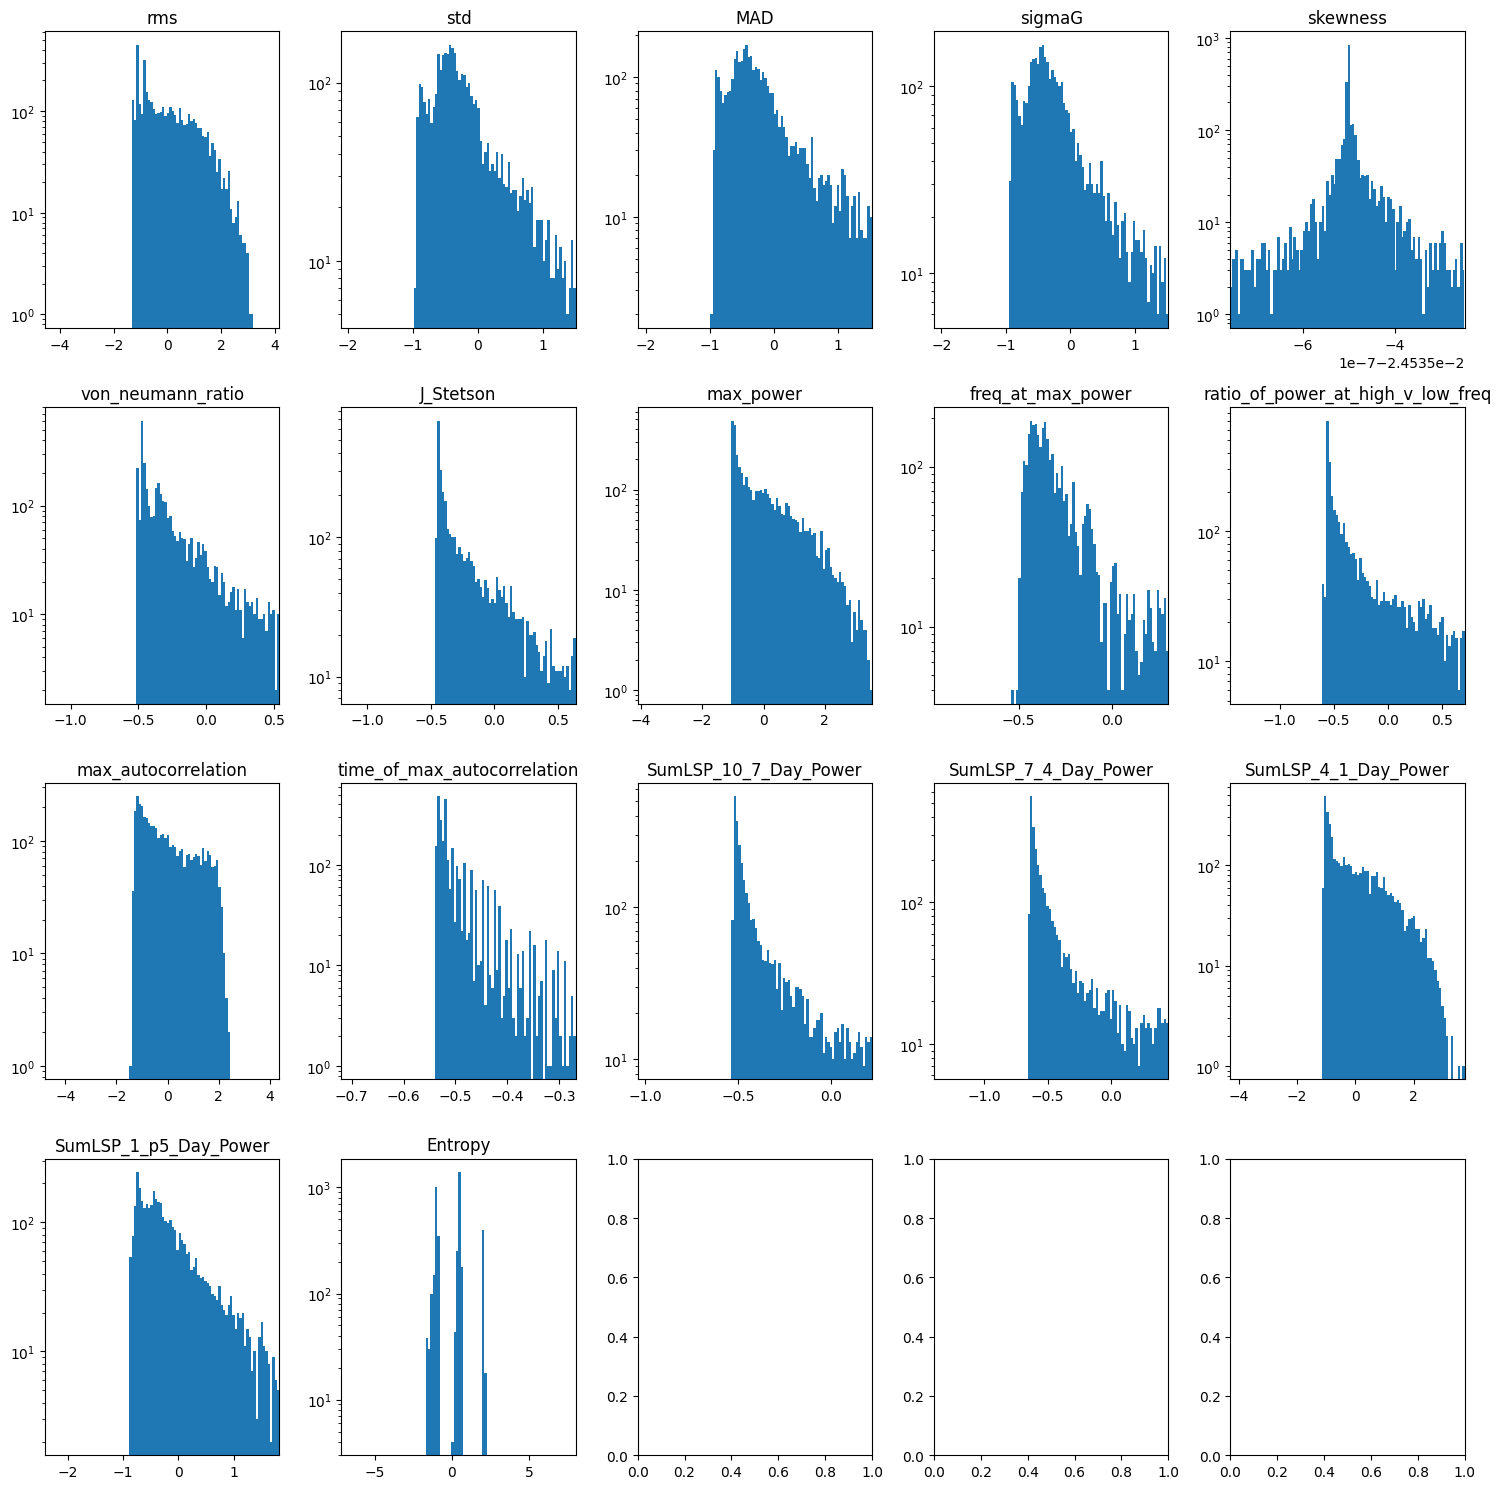

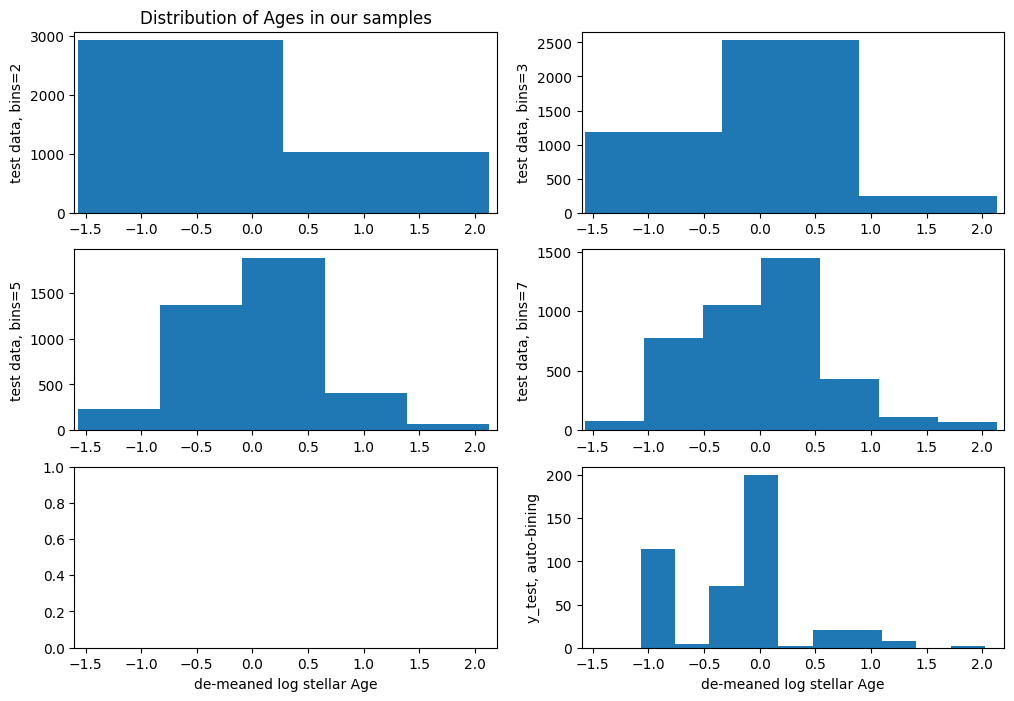

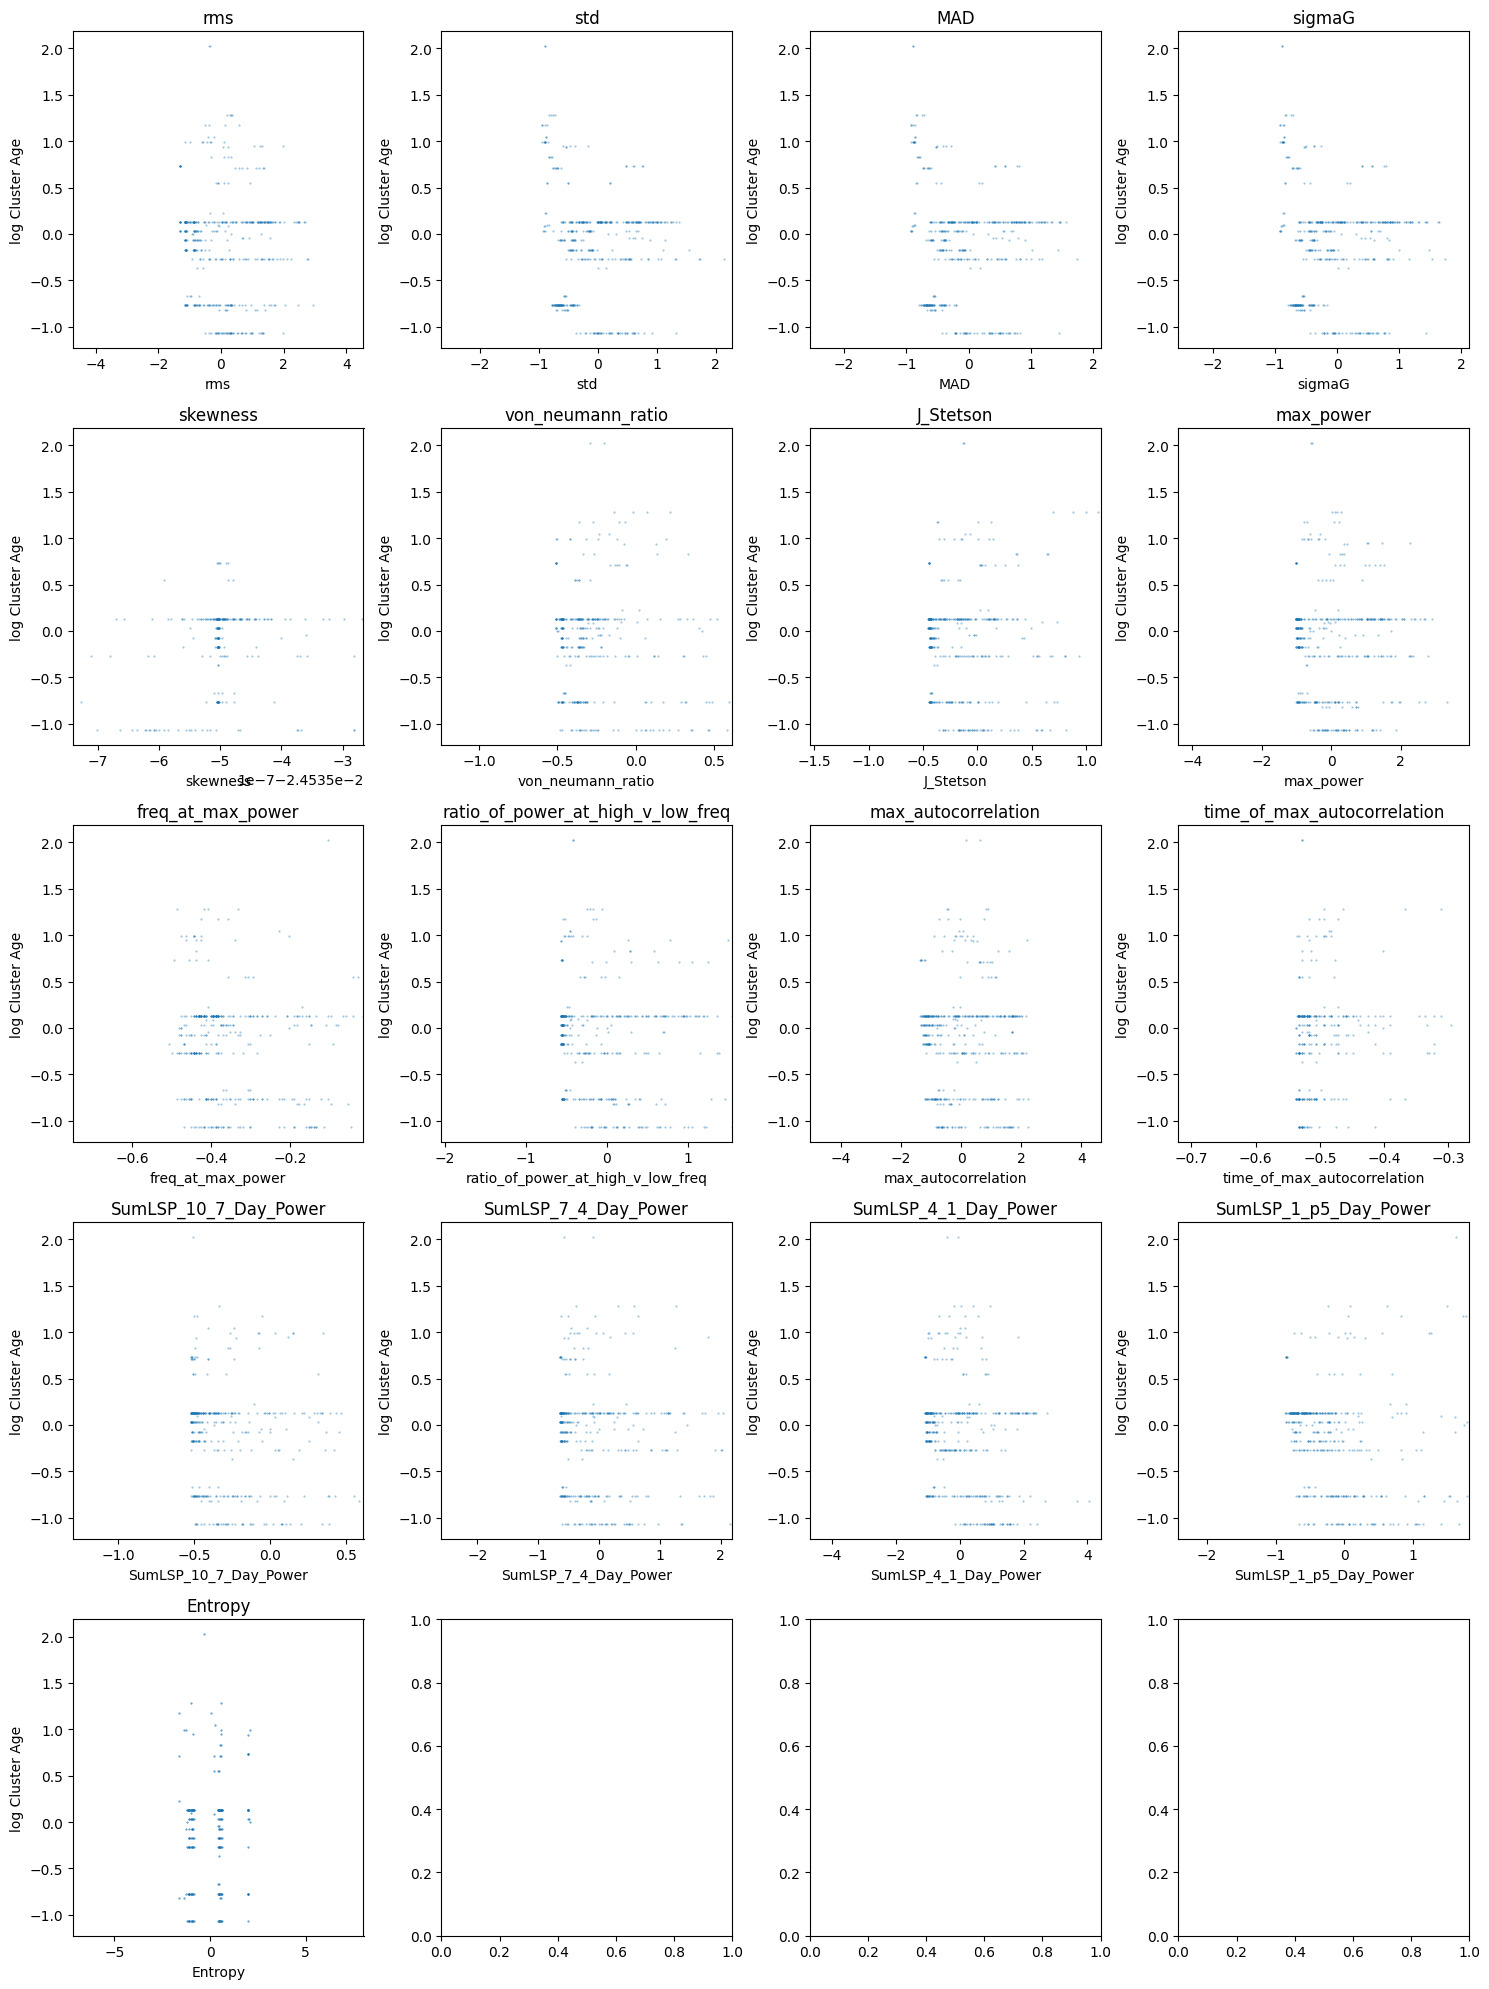

In [26]:
# Full histogram illustrating the data:
import sys
sys.path.append(pipeline_dir_path+'HelperFcns/')


from VisualizeDataset import visualize_feature_distributions, visualize_mass_bin_distribution
from VisualizeDataset import visualize_summary_stats, plot_correlation_matrix

visualize=True
if visualize:
    visualize_feature_distributions(X_train, feature_cols)
    visualize_mass_bin_distribution(y_train, y_test)
    visualize_summary_stats(X_train, y_train, feature_cols)
    plot_correlation_matrix(X_train, feature_names=ATTRIBUTES, figsize=(14, 11), annot=True)
    #plot_correlation_matrix(period_train, feature_names=None, figsize=(14, 11), annot=False)
